# Preparation

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
# Open files with correct encoding
games_2017 = pd.read_html('2017/games.xls', encoding='utf-8')[0]
games_2018 = pd.read_html('2018/games.xls', encoding='utf-8')[0]
games_2019 = pd.read_html('2019/games.xls', encoding='utf-8')[0]

players_2017 = pd.read_html('2017/player-stats.xls', encoding='utf-8')[0]
players_2018 = pd.read_html('2018/player-stats.xls', encoding='utf-8')[0]
players_2019 = pd.read_html('2019/player-stats.xls', encoding='utf-8')[0]

table_2017 = pd.read_html('2017/table.xls', encoding='utf-8')[0]
table_2018 = pd.read_html('2018/table.xls', encoding='utf-8')[0]
table_2019 = pd.read_html('2019/table.xls', encoding='utf-8')[0]

teams_2017 = pd.read_html('2017/team-stats.xls', encoding='utf-8')[0]
teams_2018 = pd.read_html('2018/team-stats.xls', encoding='utf-8')[0]
teams_2019 = pd.read_html('2019/team-stats.xls', encoding='utf-8')[0]

#### Games
The most important dataset. Contains information about the matches played per year, like time, \
day, week, who's playing, score, arena and more.
#### Players
Contains information about all players, how well they performed, what team they play on, age and more.
#### Table
Contains final ranks for the teams, scores over the season, won/draw/loss of matches, top scorer.
#### Teams
Contains information about the teams, number of players, average age, performance and more.

In [35]:
# Gather all years in one table.
tot_games = tot_teams = pd.concat((pd.concat((games_2017, games_2018)), games_2019))
tot_teams = tot_teams = pd.concat((pd.concat((teams_2017, teams_2018)), teams_2019))


<p>
We are interested in the amount of goals one team scores against the opponent.
Therefore I have chosen these features I would like to make.<p/>

<p>
AvgGls           - avg goals                          - scoring team<br>
AvgConceded      - avg conceded                       - opponent team<br>
AvgGlsHA         - avg goals on home or away venue    - scoring team<br>
Venue_H          - playing on home venue              - scoring team<br>
Venue_A          - playing on away venue              - scoring team<br>
AvgConcededHA    - avg conceded on home or away venue - opponent team<br>
AvgGlsPrVenue    - avg goals on this venue<br>
AvgPrevMatches   - avg goals scored in previous match - scoring team<br>
AvgAge           - avg age of team<br>
AvgAgeOpp        - avg age of opponent team
<p/>

In [21]:
# Drop rows where all values are NaN and iterate to change row format of Score from "2-1" to two rows with 2 and 1 as Score.
# Only choosing the columns I am interested in.
iter_data = tot_games.loc[:, ['Score', 'Home', 'Away', 'Venue', 'Attendance']].dropna().reset_index()
df_games = pd.DataFrame([], index=[], columns=['Score', 'Home', 'Away', 'Venue', 'Attendance'])

for (i, row) in iter_data.iterrows():
    homeGls = row[1][0]
    awayGls = row[1][2]
    home = row[2]
    away = row[3]
    # første kamp rad
    row[1] = homeGls
    row[5] = 1
    df_games = df_games.append(row.drop(['index']))
    # andre kamp rad
    row[1] = awayGls
    row[2] = away
    row[3] = home
    row[5] = 0
    df_games = df_games.append(row.drop(['index']))

# Making new column names and removing two matches where IF Fløya shows up.
df_games = df_games.rename(columns={'Home': 'Team', 'Away': 'Opponent', 'Attendance': 'Venue_HA'}).reset_index(drop=True)
df_games = df_games.iloc[:-4]
df_games

,Score,Team,Opponent,Venue,Venue_HA
0,1,Medkila,Sandviken,Harstad Stadion,1
1,1,Sandviken,Medkila,Harstad Stadion,0
2,2,Avaldsnes,Vålerenga,Avaldsnes Idrettssenter,1
3,1,Vålerenga,Avaldsnes,Avaldsnes Idrettssenter,0
4,2,Grand Bodø,Arna-Bjørnar,Nordlandshallen,1
...,...,...,...,...,...
777,0,Lyn,Kolbotn,Strømmen Stadion,0
778,0,Arna-Bjørnar,Vålerenga,Arna Idrettspark,1
779,2,Vålerenga,Arna-Bjørnar,Arna Idrettspark,0
780,1,Fart,Klepp,Fart Kunstgress,1


In [22]:
# Making a dataframe of averages from the teams df.
# list of team names
all_teams = tot_teams.drop_duplicates(('Unnamed: 0_level_0', 'Squad'), ignore_index=True)['Unnamed: 0_level_0']

for (i, row) in all_teams.iterrows():
    # Number of matches
    games_played = len(df_games.loc[df_games['Team'] == row.values[0]])
    games_played_venue = games_played/2
    
    # Calculating averages
    avgGls = sum(map(int, df_games.loc[df_games['Team'] == row.values[0]]['Score'].values))/games_played
    avgConceded = sum(map(int, df_games.loc[df_games['Opponent'] == row.values[0]]['Score'].values))/games_played
    avgGlsHome = sum(map(int, df_games.loc[(df_games['Team'] == row.values[0]) & (df_games['Venue_HA'] == 1)]['Score'].values))/games_played_venue
    avgGlsAway = sum(map(int, df_games.loc[(df_games['Team'] == row.values[0]) & (df_games['Venue_HA'] == 0)]['Score'].values))/games_played_venue
    avgConcededHome = sum(map(int, df_games.loc[(df_games['Opponent'] == row.values[0]) & (df_games['Venue_HA'] == 0)]['Score'].values))/games_played_venue
    avgConcededAway = sum(map(int, df_games.loc[(df_games['Opponent'] == row.values[0]) & (df_games['Venue_HA'] == 1)]['Score'].values))/games_played_venue
    avgAge = sum(tot_teams.loc[tot_teams[('Unnamed: 0_level_0', 'Squad')] == row.values[0], ('Unnamed: 2_level_0', 'Age')])/len(tot_teams.loc[tot_teams[('Unnamed: 0_level_0', 'Squad')] == row.values[0], ('Unnamed: 2_level_0', 'Age')])
    
    all_teams.loc[i, 'AvgGls'] = avgGls
    all_teams.loc[i, 'AvgConceded'] = avgConceded
    all_teams.loc[i, 'AvgGlsHome'] = avgGlsHome
    all_teams.loc[i, 'AvgGlsAway'] = avgGlsAway
    all_teams.loc[i, 'AvgConcededHome'] = avgConcededHome
    all_teams.loc[i, 'AvgConcededAway'] = avgConcededAway
    all_teams.loc[i, 'AvgAge'] = avgAge

all_teams

,Squad,AvgGls,AvgConceded,AvgGlsHome,AvgGlsAway,AvgConcededHome,AvgConcededAway,AvgAge
0,Arna-Bjørnar,1.787879,1.439394,2.030303,1.545455,1.272727,1.606061,22.100000
1,Avaldsnes,1.734375,1.343750,2.031250,1.437500,1.093750,1.593750,24.633333
2,Grand Bodø,1.136364,3.204545,1.181818,1.090909,2.772727,3.636364,23.050000
3,Klepp,1.833333,0.969697,2.090909,1.575758,0.757576,1.181818,24.533333
4,Kolbotn,1.261538,1.738462,1.292308,1.230769,1.630769,1.846154,21.633333
5,LSK Kvinner,2.876923,0.784615,3.107692,2.646154,0.707692,0.861538,24.533333
6,Medkila,0.409091,3.136364,0.454545,0.363636,2.727273,3.545455,20.900000
7,Røa,1.875000,1.562500,2.343750,1.406250,1.781250,1.343750,22.800000
8,Sandviken,1.615385,1.400000,1.907692,1.323077,1.169231,1.630769,25.366667
9,Stabæk,1.378788,1.560606,1.606061,1.151515,1.151515,1.969697,24.600000


In [23]:
# Making a df for venues to find AvgGlsPrVenue
# Note some of the venues have few entries, and therefore bad averages, for example Strømmen Stadion.
# (Average for IF Fløya was 5.0 over two games, therefore I removed them)
df_venues = df_games.loc[:, ['Venue']].drop_duplicates('Venue', ignore_index=True)

for (i, row) in df_venues.iterrows():
    venue = df_games.loc[df_games['Venue'] == row.values[0]]['Score'].values
    avgGlsPrVenue = sum(map(int, venue))/len(venue)
    df_venues.loc[i, 'AvgGlsPrVenue'] = avgGlsPrVenue
    
df_venues

,Venue,AvgGlsPrVenue
0,Harstad Stadion,1.590909
1,Avaldsnes Idrettssenter,1.596774
2,Nordlandshallen,1.977273
3,Røabanen,2.000000
4,LSK-hallen,1.875000
5,Ørn Arena,1.260870
6,Arna Idrettspark,1.612903
7,Vallhall Arena,1.166667
8,Sofiemyr stadion,1.479167
9,Nadderud Stadion,1.406250


In [32]:
# Making final dfs for model training
# y_all: labels
# X_all: features, x-variables
y_all = df_games['Score']
X_all = df_games.drop(['Score'], axis=1)

# Adding column names
for i in ['AvgGls', 'AvgConceded', 'AvgGlsHA', 'Venue_H', 'Venue_A', 'AvgConcededHA', 'AvgGlsPrVenue', 'AvgAge', 'AvgAgeOpp']:
    X_all[i] = 0

# Inputing values in columns
for (i, row) in X_all.iterrows():
    X_all.loc[i, 'AvgGls'] = all_teams.loc[all_teams['Squad'] == row.values[0], 'AvgGls'].values[0]
    X_all.loc[i, 'AvgConceded'] = all_teams.loc[all_teams['Squad'] == row.values[1], 'AvgConceded'].values[0]
    X_all.loc[i, 'AvgGlsPrVenue'] = df_venues.loc[df_venues['Venue'] == row.values[2], 'AvgGlsPrVenue'].values[0]
    X_all.loc[i, 'AvgAge'] = all_teams.loc[all_teams['Squad'] == row.values[0], 'AvgAge'].values[0]
    X_all.loc[i, 'AvgAgeOpp'] = all_teams.loc[all_teams['Squad'] == row.values[1], 'AvgAge'].values[0]
    
    # team is playing on home venue
    if row.values[3] == 1:
        X_all.loc[i, 'AvgGlsHA'] = all_teams.loc[all_teams['Squad'] == row.values[0], 'AvgGlsHome'].values[0]
        X_all.loc[i, 'Venue_H'] = 1
        X_all.loc[i, 'AvgConcededHA'] = all_teams.loc[all_teams['Squad'] == row.values[0], 'AvgConcededAway'].values[0]
    # team is playing on away venue
    elif row.values[3] == 0:
        X_all.loc[i, 'AvgGlsHA'] = all_teams.loc[all_teams['Squad'] == row.values[0], 'AvgGlsAway'].values[0]
        X_all.loc[i, 'Venue_A'] = 1
        X_all.loc[i, 'AvgConcededHA'] = all_teams.loc[all_teams['Squad'] == row.values[0], 'AvgConcededHome'].values[0]

# Dropping columns with categorical data
X_all = X_all.drop(['Team', 'Opponent', 'Venue', 'Venue_HA'], axis=1)
X_all.head()

,AvgGls,AvgConceded,AvgGlsHA,Venue_H,Venue_A,AvgConcededHA,AvgGlsPrVenue,AvgAge,AvgAgeOpp
0,0.409091,1.400000,0.454545,1,0,3.545455,1.590909,20.900000,25.366667
1,1.615385,3.136364,1.323077,0,1,1.169231,1.590909,25.366667,20.900000
2,1.734375,1.369231,2.031250,1,0,1.593750,1.596774,24.633333,25.533333
3,1.723077,1.343750,1.692308,0,1,1.138462,1.596774,25.533333,24.633333
4,1.136364,1.439394,1.181818,1,0,3.636364,1.977273,23.050000,22.100000


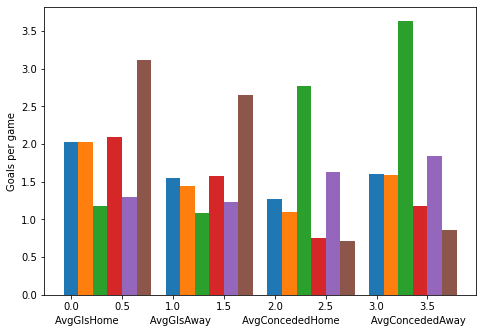

In [34]:
x=[2,3,4]
X = np.arange(4)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['AvgGlsHome', 'AvgGlsAway', 'AvgConcededHome', 'AvgConcededAway']

for i in range(6):
    data = list(all_teams.loc[i, ['AvgGlsHome', 'AvgGlsAway', 'AvgConcededHome', 'AvgConcededAway']])
    ax.bar(X + i*1/7, data, width=1/7)

plt.xlabel('AvgGlsHome          AvgGlsAway          AvgConcededHome          AvgConcededAway')
plt.ylabel('Goals per game')
# Her er en enkel bar graf som viser sammenhengen mellom gjennomsnitt mål og innsluppet mål på hjemme
# og bortebane. 
# Lag på hjemmebane scorer flere mål og slipper inn færre mål enn på bortebane.
# Fikk ikke til å sette labels på gruppene men jeg håper det er tydelig nok
plt.show()

In [33]:
%store y_all
%store X_all

Stored 'y_all' (Series)
Stored 'X_all' (DataFrame)
